# Week 4: Training a model - Regression

In [50]:
# Python ≥3.9 is required
import sys
assert sys.version_info >= (3, 9)

# Scikit-Learn ≥1.0 is required
import sklearn
assert sklearn.__version__ >= "1.0"

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Precision options
np.set_printoptions(precision=2)
pd.options.display.float_format = '{:.3f}'.format

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
# ignore convergence warnings for the purpose of this class
warnings.filterwarnings(action="ignore", category=sklearn.exceptions.ConvergenceWarning)



## 1. Load the data

Let's load the data have we pre-processed in the previous notebook.

In [2]:
train_set_prepared = pd.read_csv("../datasets/prepared/kd-housing-train.csv")
test_set_prepared = pd.read_csv("../datasets/prepared/kd-housing-test.csv")

X_train = train_set_prepared.drop(columns=["price"])
y_train = train_set_prepared["price"]

X_test = test_set_prepared.drop(columns=["price"])
y_test = test_set_prepared["price"]

In [3]:
X_train.shape

(17290, 23)

In [4]:
X_test.shape

(4323, 23)

In [5]:
y_train.shape

(17290,)

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17290 entries, 0 to 17289
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bedrooms            17290 non-null  float64
 1   bathrooms           17290 non-null  float64
 2   sqft_living         17290 non-null  float64
 3   sqft_lot            17290 non-null  float64
 4   floors              17290 non-null  float64
 5   view                17290 non-null  float64
 6   condition           17290 non-null  float64
 7   grade               17290 non-null  float64
 8   sqft_lot15          17290 non-null  float64
 9   zipcode_group_zg_0  17290 non-null  float64
 10  zipcode_group_zg_1  17290 non-null  float64
 11  zipcode_group_zg_2  17290 non-null  float64
 12  zipcode_group_zg_3  17290 non-null  float64
 13  zipcode_group_zg_4  17290 non-null  float64
 14  zipcode_group_zg_5  17290 non-null  float64
 15  zipcode_group_zg_6  17290 non-null  float64
 16  zipc

## 2. Linear Regression models

We will start by looking at the Linear Regression model, the simplest Regression model there is. There are two different ways to train it:

* Using a direct “closed-form” equation that directly computes the model parameters that best fit the model to the training set (i.e., the model parameters that minimize the cost function over the training set).

* Using an iterative optimization approach called Gradient Descent (GD) that gradually tweaks the model parameters to minimize the cost function over the training set, eventually converging to the same set of parameters as the first method. We will look at a few variants of Gradient Descent: Batch GD, Mini-batch GD, and Stochastic GD. This will be used again later on, when we will be seeing Neural Networks

### 2.1 Closed form solution: Normal Equation (Ordinary Least Squares)

We will use the `LinearRegression` class from `scikit-learn`

In [7]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg.intercept_, lin_reg.coef_

(-5.598858484431538e+17,
 array([-2.47e+04,  3.13e+03,  1.63e+05,  1.04e+04, -7.96e+03,  4.54e+04,
         2.19e+04,  6.58e+04, -7.72e+03,  5.60e+17,  5.60e+17,  5.60e+17,
         5.60e+17,  5.60e+17,  5.60e+17,  5.60e+17,  5.60e+17,  5.60e+17,
         5.84e+05,  1.13e+05, -6.34e+04, -2.02e+04, -2.86e+03]))

In [8]:
len(lin_reg.coef_)

23

Let’s try it out on a few instances from the training set:

In [9]:
some_data = X_train.iloc[:10]
some_labels = y_train.iloc[:10]
print("Predictions:", lin_reg.predict(some_data))
print("Labels:", list(some_labels))

Predictions: [ 457600.  148992. 1375232.  213312.  404800.  290240.  689344.  234304.
  660992.  523136.]
Labels: [379000.0, 173000.0, 1393000.0, 390000.0, 440500.0, 267300.0, 750000.0, 288000.0, 845000.0, 464950.0]


It mostly works, although the predictions are not exactly accurate. Let’s measure this regression model’s RMSE on the whole training set using Scikit-Learn’s `mean_squared_error()` function and computing its square root:

In [10]:
from sklearn.metrics import mean_squared_error
y_pred_lr = lin_reg.predict(X_train)
lin_mse = mean_squared_error(y_train, y_pred_lr)
lin_mse

28064967459.232445

In [11]:
lin_rmse = np.sqrt(lin_mse)
lin_rmse

167526.0202453113

### 2.2 Linear Regression using Gradient Descent

Gradient Descent is a generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The concept behind Gradient Descent is to modify parameters iteratively to minimize a cost function.

The MSE cost function for a Linear Regression model is a convex function, which means that if you pick any two points on the curve, the line segment joining them never crosses the curve. This implies that there are no local minima, just one global minimum. It is also a continuous function with a slope that never changes abruptly.

#### 2.2.1 Batch Gradient Descent

No example on this as on large datasets its not really feasible.

#### 2.2.2 Stochastic Gradient Descent

To perform Linear Regression using Stochastic GD with Scikit-Learn, you can use the `SGDRegressor` class. It defaults to optimizing the squared error cost function. 

In [12]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(
    loss="squared_error", # default cost function (MSE)
    max_iter=2000,   # max numer of epochs. epoch = 1 full iteration over the training set
    penalty=None,
    eta0=1e-3,  # initial learning rate
    tol=1e-3,   # stopping criterion tolerance. stop searching for a minimum 
                # (or maximum) once some tolerance is achieved, i.e. 
                # once you're close enough.
    random_state=77
)

sgd_reg.fit(X_train, y_train)
print(f"SGD Regressor intercept: {sgd_reg.intercept_})")
print(f"SGD Regressor coefficient: {sgd_reg.coef_}")

SGD Regressor intercept: [617233.14])
SGD Regressor coefficient: [ -26465.9     3960.11  166890.12    9785.09   -9283.81   47947.42
   22041.67   65475.52   -7549.64 -128317.68 -251401.32  178259.88
 -207806.75 -172014.33  -18649.67  270336.15  428669.8   518157.06
  498916.97  115957.43  -17641.41  -22332.87   -3167.11]


In [13]:
print("Predictions:", sgd_reg.predict(some_data))
print("Labels:", list(some_labels))

Predictions: [ 455016.95  146463.2  1392096.36  210096.8   409172.5   290642.96
  687936.27  230551.52  660043.18  517299.32]
Labels: [379000.0, 173000.0, 1393000.0, 390000.0, 440500.0, 267300.0, 750000.0, 288000.0, 845000.0, 464950.0]


In [14]:
y_pred_sgd = sgd_reg.predict(X_train)
sgd_mse = mean_squared_error(y_pred_sgd, y_train)
sgd_rmse = np.sqrt(sgd_mse)
sgd_rmse

169752.25944316038

### 2.3 Learning Curves

Learning curves in scikit-learn can be used to assess how models will perform with varying numbers of training samples. This is achieved by monitoring the training and validation scores (e.g. RMSE) with an increasing number of training samples

/opt/homebrew/Caskroom/miniforge/base/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached be

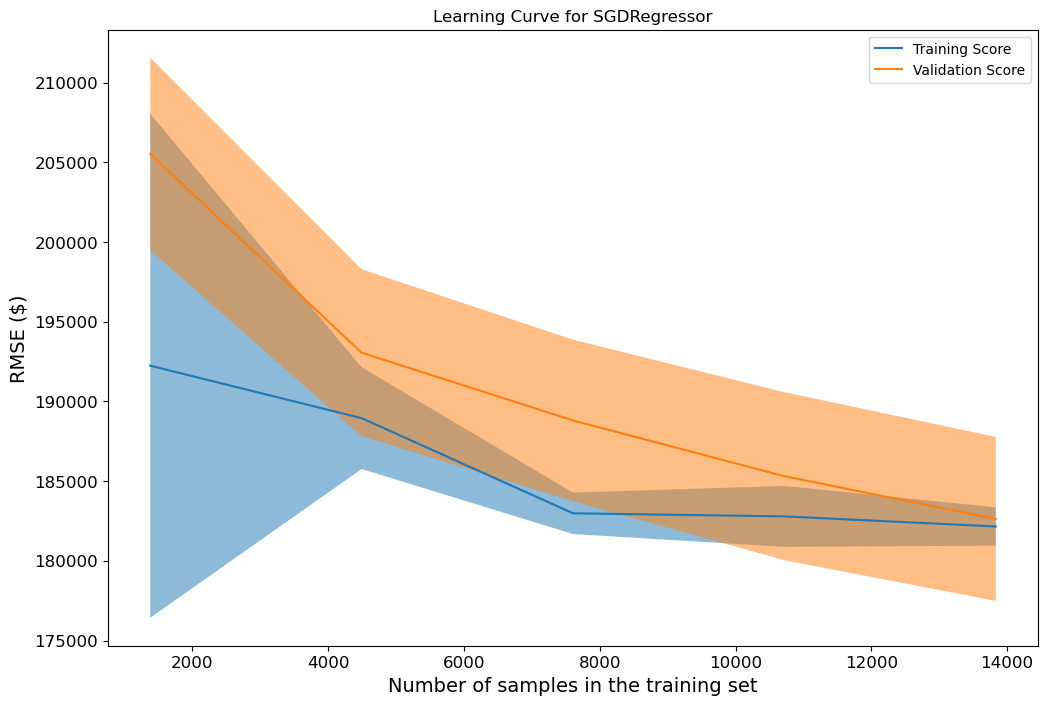

In [51]:
from sklearn.model_selection import LearningCurveDisplay

# create an SGD regressor object
sgd_reg = SGDRegressor(
    loss="squared_error",
    max_iter=2000,
    penalty=None,
    eta0=0.0001,
    tol=1e-3,
)

# create an empty figure with an axis system
fig, ax = plt.subplots(figsize=(12, 8))

# generate the learning curves using the SGD regressor created above
LearningCurveDisplay.from_estimator(
    sgd_reg,
    X_train,
    y_train,
    # see possible scoring parameters:
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    scoring="neg_root_mean_squared_error", #  negated RMSE 
    score_type="both", # show both training and validation RMSE
    negate_score=True, # need to negate as our scoring is "negated"
    score_name="RMSE ($)",
    n_jobs=-1,  # use all the CPU processors
    ax=ax # figure axis where the curves will be drawn
)

# personalize legend and figure title
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Validation Score"])
ax.set_title(f"Learning Curve for {sgd_reg.__class__.__name__}")
plt.show()

What can you infer from the graph? Does the SGD regressor overfits?

**Exercise:** draw the Learning curves without showing the standard deviation of the RMSE (i.e. without shaded area).

/opt/homebrew/Caskroom/miniforge/base/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached be

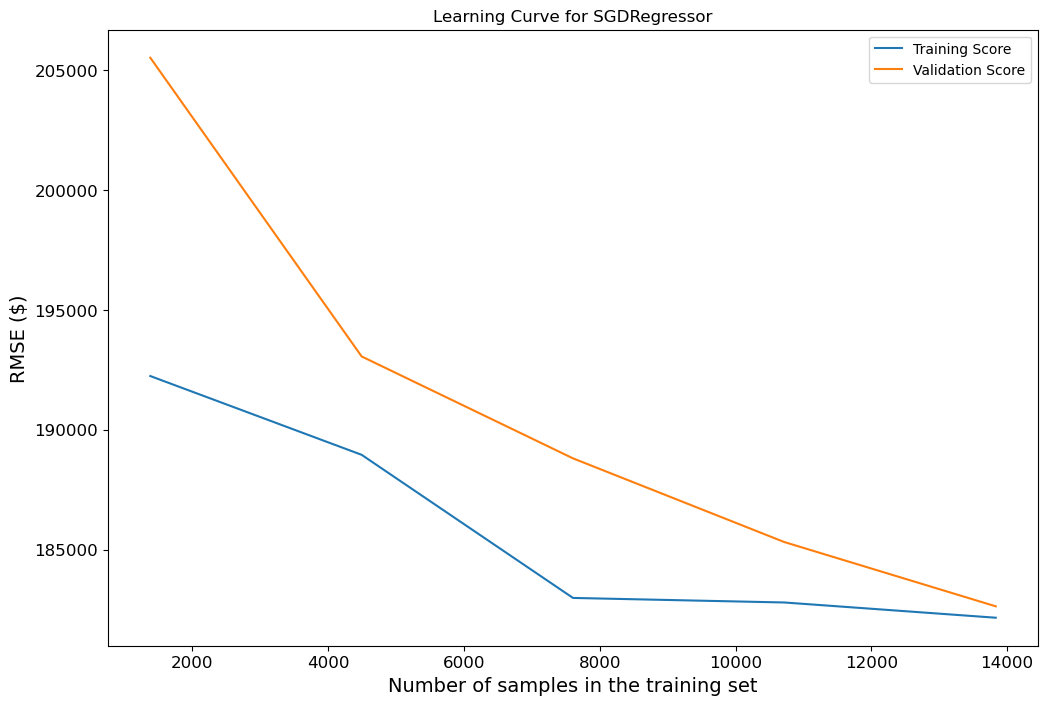

In [52]:
# write your solution here or edit the cell above
# create an SGD regressor object
sgd_reg = SGDRegressor(
    loss="squared_error",
    max_iter=2000,
    penalty=None,
    eta0=0.0001,
    tol=1e-3,
)

# create an empty figure with an axis system
fig, ax = plt.subplots(figsize=(12, 8))

# generate the learning curves using the SGD regressor created above
LearningCurveDisplay.from_estimator(
    sgd_reg,
    X_train,
    y_train,
    # see possible scoring parameters:
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    scoring="neg_root_mean_squared_error", #  negated RMSE 
    score_type="both", # show both training and validation RMSE
    negate_score=True, # need to negate as our scoring is "negated"
    score_name="RMSE ($)",
    std_display_style=None, # do not display the error bar
    n_jobs=-1,  # use all the CPU processors
    ax=ax # figure axis where the curves will be drawn
)

# personalize legend and figure title
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Validation Score"])
ax.set_title(f"Learning Curve for {sgd_reg.__class__.__name__}")
plt.show()

**Exercise (at home):** draw the Learning curves using the $R^2$ score as evaluation metric

/opt/homebrew/Caskroom/miniforge/base/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached be

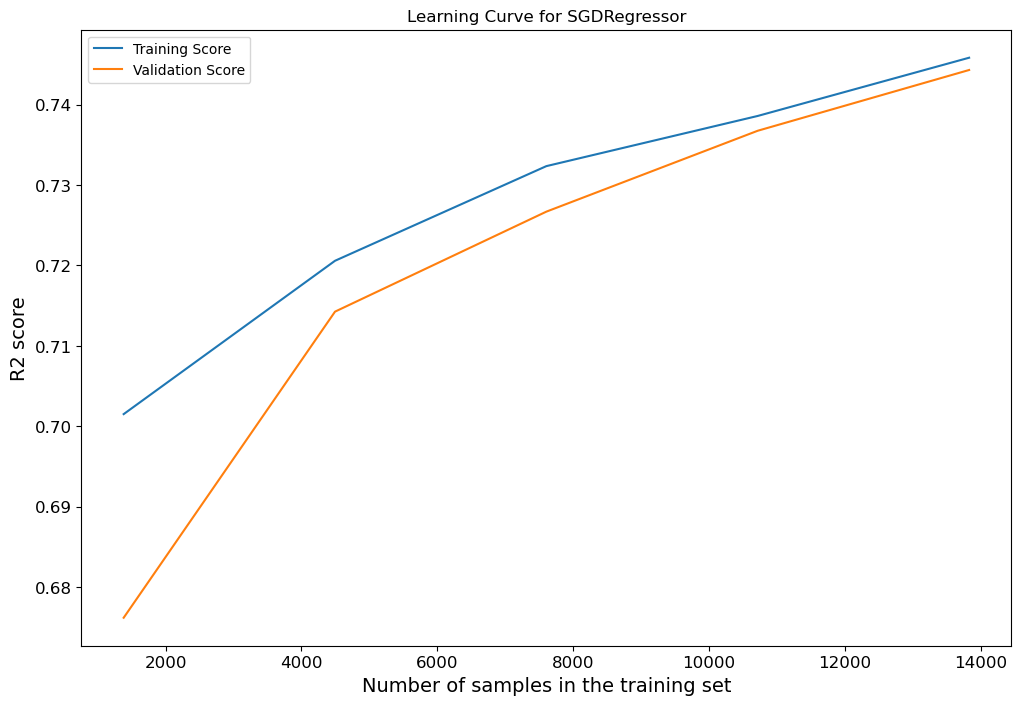

In [17]:
# write your solution here

# create an SGD regressor object
sgd_reg = SGDRegressor(
    loss="squared_error",
    max_iter=2000,
    penalty=None,
    eta0=0.0001,
    tol=1e-3,
)

# create an empty figure with an axis system
fig, ax = plt.subplots(figsize=(12, 8))

# generate the learning curves using the SGD regressor created above
LearningCurveDisplay.from_estimator(
    sgd_reg,
    X_train,
    y_train,
    # see possible scoring parameters:
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    scoring="r2", #  R2 score
    score_type="both", # show both training and validation RMSE
    score_name="R2 score",
    std_display_style=None, # do not display the error bar
    n_jobs=-1,  # use all the CPU processors
    ax=ax # figure axis where the curves will be drawn
)

# personalize legend and figure title
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Validation Score"])
ax.set_title(f"Learning Curve for {sgd_reg.__class__.__name__}")
plt.show()

### 2.3 Early stopping

Early stopping technique stops the training phase when the performance (e.g. the loss function) does not improve on a validation set after a certain number of epochs.

**Exercise:** Here below there is an example of Earlt Stopping implementation. Please complete the missing lines 

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.base import clone

# create an SGD regressor object
sgd_reg = SGDRegressor(
    loss="squared_error",
    max_iter=1, # train only for one epoch at the time
    penalty=None,
    eta0=1e-4,
    tol=1,
    warm_start=True,
    learning_rate="constant" # the learning rate remains constant throughout training
)

min_val_error: float = float("inf") # positive infinity
best_epoch: int | None = None
best_model: SGDRegressor | None = None

n_epochs = 2000

train_errors = np.zeros(n_epochs)
val_errors = np.zeros(n_epochs)

# partition the training set into a smaller training and validation set. Assign 25% of the samples to validation
X_train_es, X_val_es, y_train_es, y_val_es = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42
)

for epoch in range(2000):
    sgd_reg.fit(X_train_es, y_train_es) # as "warm_start" is true it will keep on training at each iteration - online learning
    # make prediction on the training set
    y_train_pred = sgd_reg.predict(X_train_es)
    # make predictions on the validation set
    y_val_pred = sgd_reg.predict(X_val_es)
    # compute the MSE on the training set
    train_error = mean_squared_error(y_train_es, y_train_pred)
    # compute the MSE on the validation set
    val_error = mean_squared_error(y_val_es, y_val_pred)
    # check if the the current validation error is smaller than the minimum validation error
    # if so update minimum validation error, best epoch and best model
    if val_error < min_val_error:
        min_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)
    # set train and validation error for the current epoch
    train_errors[epoch] = train_error
    val_errors[epoch] = val_error

Let's plot the training and validation errors (also called losses):

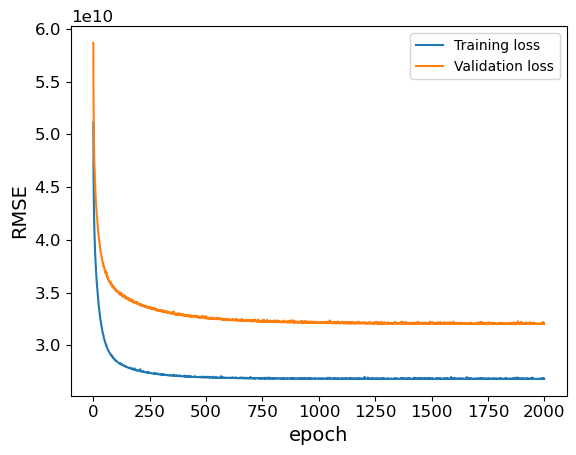

In [40]:
plt.plot(train_errors, label="Training loss")
plt.plot(val_errors, label="Validation loss")
plt.ylabel("RMSE")
plt.xlabel("epoch")
plt.legend()
plt.show()

There is a clear plateau in the validation loss. Let's see which was the best epoch and the best model:

In [20]:
best_epoch

1980

In [21]:
best_model

SGDRegressor(eta0=0.0001, learning_rate='constant', max_iter=1, penalty=None,
             tol=1, warm_start=True)

### 3. Polynomial Regression

What if your data is more complex than a straight line (or an (N-1)-dimensional plane in an N-dimensional space)? Surprisingly, you can use a linear model to fit nonlinear data. This can be done with Polynomial Regression.

Polynomial regression relies on polynomial features, which can get features’ high-order and interaction terms. 

![poly-reg](week4/poly_best_fits.png)

For instance if you have the features $X$ $Y$, polynomial features up to degree 2 will be $1$, $X$, $Y$, $X^2$, $XY$ $Y^2$.

Polynomial features up to degree 3 will be $1$, $X$, $Y$, $X^2$, $XY$ $Y^2$, $X^3$, $X^2Y$, $XY^2$, $Y^3$.


In [22]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)

In [23]:
X_train_poly.shape

(17290, 299)

In [24]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, y_train)

lin_reg.intercept_, lin_reg.coef_

(-85274683665248.95,
 array([ 3.04e+15,  8.57e+14, -1.08e+13,  6.10e+12,  7.52e+14, -1.12e+14,
        -1.84e+14,  1.70e+15, -7.70e+12, -1.21e+14, -7.75e+12,  7.74e+13,
         2.40e+14,  2.44e+14,  6.88e+14, -2.71e+13,  1.31e+14, -8.75e+13,
        -2.35e+13,  1.97e+14, -1.10e+14,  1.05e+14, -1.56e+15,  2.33e+03,
        -1.66e+02, -2.06e+04,  2.57e+03,  1.57e+04, -4.44e+02, -3.61e+03,
         1.22e+03, -2.02e+03, -3.04e+15, -3.04e+15, -3.04e+15, -3.04e+15,
        -3.04e+15, -3.04e+15, -3.04e+15, -3.04e+15, -3.04e+15,  8.08e+03,
        -7.06e+03, -3.73e+04,  9.38e+03, -1.38e+04,  1.64e+03,  1.21e+04,
        -6.70e+03, -1.59e+04, -2.21e+03,  7.79e+02,  6.40e+03,  1.09e+03,
        -8.57e+14, -8.57e+14, -8.57e+14, -8.57e+14, -8.57e+14, -8.57e+14,
        -8.57e+14, -8.57e+14, -8.57e+14,  6.07e+04, -3.07e+03,  3.63e+04,
        -1.59e+04,  1.66e+04, -4.78e+03,  1.14e+02,  9.93e+03, -9.16e+03,
         1.46e+04,  2.29e+04,  3.16e+03,  1.08e+13,  1.08e+13,  1.08e+13,
         1.08e+13

In [25]:
y_pred_poly = lin_reg.predict(
    poly_features.transform(X_train)
)
poly_mse = mean_squared_error(
    y_train, y_pred_poly
)
poly_rmse = np.sqrt(poly_mse)
poly_rmse

128734.86545170097

Our RMSE is now ~130 k\\$. This would seem an improvement over the pure linear regression RMSE. However, there is still a major issue. We are evaluating the RMSE with respect to the training set, that is the same data that we have used to train the model. If there were an overfitting issue we would not see it by computing the RMSE on the training set only.
Adding many polynomial features can increase the complexity of your model, which can cause overfitting.

To see if our Polynomial Regressor overfits we can train it in cross-validation


### 4. Model evaluation using Cross Validation

Let's try and use the function `sklearn.model_selection.cross_val_score()` to evaluate our Polynomial Regression model on the training set using a 10-fold cross-validation with RMSE as a score. Print out the mean value and the standard deviation of the RMSE across the 10 validation iterations

In [26]:
%%time
from sklearn.model_selection import cross_val_score
scores = cross_val_score(
    lin_reg, # model we want to train
    X_train_poly, # features
    y_train, # labels
    scoring='neg_root_mean_squared_error', # this is the negated MSE
    cv=10,
)

CPU times: user 22.2 s, sys: 1.24 s, total: 23.5 s
Wall time: 4.26 s


In [27]:
scores

array([-1.40e+05, -1.32e+05, -3.16e+10, -1.29e+05, -1.27e+05, -1.44e+05,
       -1.28e+05, -4.73e+12, -1.48e+05, -1.36e+05])

In [28]:
# You can also use this function to print out mean value and std of the scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", f"{scores.mean():.2f}")
    print("Standard deviation:", f"{scores.std():.2f}")

In [29]:
poly_rmse_scores = -scores
display_scores(poly_rmse_scores) 

Scores: [1.40e+05 1.32e+05 3.16e+10 1.29e+05 1.27e+05 1.44e+05 1.28e+05 4.73e+12
 1.48e+05 1.36e+05]
Mean: 476049754106.27
Standard deviation: 1417663277233.08


As we can see the average RMSE in cross validation for the Polynomial Regressor is ~137 k$. While slightly worse than the RMSE on the training data is still not a considerable degradation, and it would seem to be still better than the performance of the Linear Regressor. We can conclude that the Polynomial Regressor is not significantly affected by overfitting.

If I want to try more scoring metrics at once while performing cross-validation, and I want to get more information than just the scores themselves I can use `sklearn.model_selection.cross_validate()`.

It would be good to check the performance of the Linear Regressor in cross-validation as well. Let's do that using `cross_validate()` and evaluating the $R_2$ metric alongside the RMSE.

In [30]:
from sklearn.model_selection import cross_validate, KFold
n_splits = 10
k_fold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_res = cross_validate(
    lin_reg,
    X_train,
    y_train,
    scoring=['neg_root_mean_squared_error', 'r2'],
    cv=k_fold
)
cv_res

{'fit_time': array([0.01, 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
 'score_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'test_neg_root_mean_squared_error': array([-175290.3 , -183061.83, -167414.87, -156123.95, -169237.03,
        -167950.58, -177667.87, -174713.08, -158683.94, -154060.32]),
 'test_r2': array([0.75, 0.78, 0.78, 0.79, 0.78, 0.78, 0.8 , 0.79, 0.79, 0.78])}

In [31]:
lin_reg_rmse_scores = -cv_res['test_neg_root_mean_squared_error']
display_scores(lin_reg_rmse_scores) 

Scores: [175290.3  183061.83 167414.87 156123.95 169237.03 167950.58 177667.87
 174713.08 158683.94 154060.32]
Mean: 168420.38
Standard deviation: 9169.47


The RMSE in cross-validation for the linear regressor is 168k $. That value is basically the same as the RMSE for the training set. This is a good indicator that the Linear Regressor does not overfits at all. 

Still we have confirmed that the performance of the Polynomial Regressor is better at least in cross validation. We would still have to verify this on the test set, but we will keep that for the very last. We must use the test set only on the final chosen model.

<b>Exercise:</b> Use the function `sklearn.model_selection.cross_val_score()` to evaluate our Stochastic Gradient Regressor model on the training set using a 5-fold cross-validation using the mean absolute error (MAE) as a score. Print out the mean value and the standard deviation of the mean absolute error across the 5 validation iterations

In [32]:
# Write your solution here
scores = cross_val_score(
    sgd_reg, # model we want to train
    X_train_poly, # features
    y_train, # labels
    scoring='neg_mean_absolute_error', # this is the negated MAE
    cv=5,
)
sgd_reg_mae_scores = -scores
display_scores(sgd_reg_mae_scores) 

Scores: [2.77e+08 1.63e+10 1.99e+10 1.06e+10 1.31e+10]
Mean: 12039981334.66
Standard deviation: 6649063922.93


## 5. Regularised Linear Models

### 5.1 Ridge Regression - $\ell_2$ regularisation

Ridge Regression is a regularized version of the Linear Regression algorithm: we add to the cost function a regularization term. This term for Ridge is equal to $ \alpha \sum_{i=1}^{N}{\theta_i^2} $. This means that it forces the learning algorithm to fit not only the data but also keep the model weights as small as possible. An important thing to note that the regularization term should only be added to the cost function during training. Once the model is trained, you want to use the unregularized performance measure to evaluate the model’s performance.

Ridge regression is a type of $\ell_2$ regularisation, because the regularisation term is equal to half the square of the $\ell_2$ norm of the weight vector.

In [33]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=25, solver="cholesky")
cv_res = cross_validate(
    ridge_reg,
    X_train_poly,
    y_train,
    scoring=['neg_root_mean_squared_error', 'r2'],
    cv=k_fold
)
cv_res

{'fit_time': array([0.11, 0.29, 0.29, 0.29, 0.38, 0.3 , 0.3 , 0.29, 0.28, 0.29]),
 'score_time': array([0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.01, 0.  , 0.  , 0.  ]),
 'test_neg_root_mean_squared_error': array([-143860.6 , -140201.39, -141927.67, -127391.43, -133134.53,
        -140817.37, -133473.27, -138920.46, -128476.96, -128185.81]),
 'test_r2': array([0.83, 0.87, 0.84, 0.86, 0.86, 0.85, 0.89, 0.87, 0.86, 0.85])}

In [34]:
ridge_rmse_scores = -cv_res['test_neg_root_mean_squared_error']
display_scores(ridge_rmse_scores) 

Scores: [143860.6  140201.39 141927.67 127391.43 133134.53 140817.37 133473.27
 138920.46 128476.96 128185.81]
Mean: 135638.95
Standard deviation: 5927.65


Our 10-fold CV RMSE is now ~135.6k $, which is marginally better than the unregularized Polynomial Regression. We should also notice that regularisation has decreased the standard deviation of our metric across the various folds.

At the moment, this is our best-performing model.

**NOTE**: If we create an `SGDRegressor` with "squared_error" loss and non-null penalty (default penalty is "l2") it will approximate a Ridge Regressor.

**Exercise (at home):** Train an `SGDRegressor` with "l2" penalty and early stopping for 2000 epochs on `X_train_poly` and `y_train`. You can use the previous early stopping example as a source of inspiration.

In [47]:
# write your solution here
# create an SGD regressor object
sgd_reg = SGDRegressor(
    loss="squared_error",
    max_iter=1, # train only for one epoch at the time
    penalty="l2", # can be omitted as it is the default value
    eta0=1e-4,
    tol=1,
    warm_start=True,
    learning_rate="constant" # the learning rate remains constant throughout training
)

min_val_error: float = float("inf") # positive infinity
best_epoch: int | None = None
best_model: SGDRegressor | None = None

n_epochs = 2000
stop_after_epochs = 20

train_errors = np.zeros(n_epochs)
val_errors = np.zeros(n_epochs)

# partition the training set into a smaller training and validation set. Assign 25% of the samples to validation
X_train_es, X_val_es, y_train_es, y_val_es = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42
)

for epoch in range(2000):
    sgd_reg.fit(X_train_es, y_train_es) # as "warm_start" is true it will keep on training at each iteration - online learning
    # make prediction on the training set
    y_train_pred = sgd_reg.predict(X_train_es)
    # make predictions on the validation set
    y_val_pred = sgd_reg.predict(X_val_es)
    # compute the MSE on the training set
    train_error = mean_squared_error(y_train_es, y_train_pred)
    # compute the MSE on the validation set
    val_error = mean_squared_error(y_val_es, y_val_pred)
    # check if the the current validation error is smaller than the minimum validation error
    # if so update minimum validation error, best epoch and best model
    if val_error < min_val_error:
        min_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

    if (stop_epoch := epoch) - best_epoch > stop_after_epochs:
        print(f"Early stopping at epoch {epoch}")
        break

    # set train and validation error for the current epoch
    train_errors[epoch] = train_error
    val_errors[epoch] = val_error

Early stopping at epoch 505


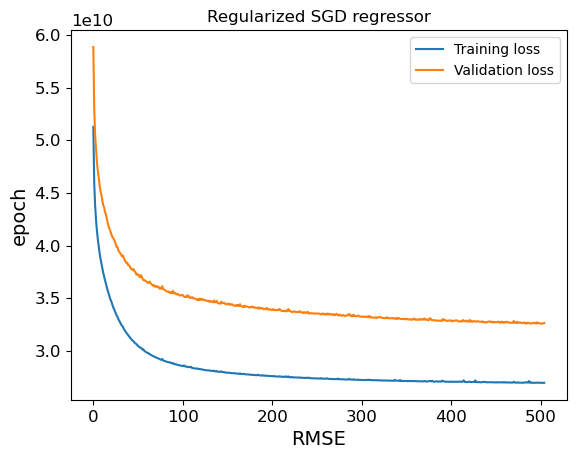

In [49]:
plt.plot(train_errors[:stop_epoch], label="Training loss")
plt.plot(val_errors[:stop_epoch], label="Validation loss")
plt.xlabel("RMSE")
plt.ylabel("epoch")
plt.title("Regularized SGD regressor")
plt.legend()
plt.show()

### 5.2  Lasso Regression - $\ell_1$ regularisation

Lasso Regression is a regularized version of the Linear Regression algorithm: we add to the cost function a regularization term. This term for Lasso is equal to $ \alpha \sum_{i=1}^{N}{\mid \theta_i \mid} $.


Lasso regression is a type of $\ell_1$ regularisation, because the regularisation term is equal to the $\ell_1$ norm of the weight vector.

While $\ell_2$ regularisation guarantees that all the weights are kept uniformly small, $\ell_1$ regularisation tends to eliminate the weights of the least important features. The result of Lasso regularisation is a sparse model.


**Exercise:** train a `Lasso` regressor in cross validation and evaluate the average RMSE. Check the scikit-learn documentation and try a few values of $\alpha$. How does it compare to the Ridge regressor?

In [37]:
# Write you solution here:
from sklearn.linear_model import Lasso
ridge_reg = Lasso(alpha=2.5)
cv_res = cross_validate(
    ridge_reg,
    X_train_poly,
    y_train,
    scoring=['neg_root_mean_squared_error', 'r2'],
    cv=k_fold
)
lasso_rmse_scores = -cv_res['test_neg_root_mean_squared_error']
display_scores(lasso_rmse_scores) 

Scores: [157093.3  143012.69 140620.71 128170.36 132516.67 139921.37 130147.47
 138492.77 131973.7  128035.61]
Mean: 136998.46
Standard deviation: 8452.28


### 5.3 ElasticNet

ElasticNet combines $\ell_1$ and $\ell_2$ regularisation.


In [38]:
from sklearn.linear_model import ElasticNet
el_net = ElasticNet(alpha=25, l1_ratio=0.1, max_iter=10000)
cv_res = cross_validate(
    el_net,
    X_train_poly,
    y_train,
    scoring=['neg_root_mean_squared_error', 'r2'],
    cv=k_fold
)
cv_res

{'fit_time': array([0.57, 0.42, 0.52, 0.38, 0.43, 0.2 , 0.39, 0.36, 0.54, 0.37]),
 'score_time': array([0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]),
 'test_neg_root_mean_squared_error': array([-273684.95, -290343.6 , -277157.79, -258894.84, -272961.46,
        -268025.23, -292559.02, -288252.1 , -262258.45, -257086.8 ]),
 'test_r2': array([0.38, 0.45, 0.4 , 0.42, 0.43, 0.44, 0.45, 0.42, 0.42, 0.39])}

In [39]:
elnet_rmse_scores = -cv_res['test_neg_root_mean_squared_error']
display_scores(elnet_rmse_scores) 

Scores: [273684.95 290343.6  277157.79 258894.84 272961.46 268025.23 292559.02
 288252.1  262258.45 257086.8 ]
Mean: 274122.42
Standard deviation: 12302.26
